In [90]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_json_to_s3

In [92]:
# Load latest player stats from S3
df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')

# Set player as index and filter for meaningful playing time
df.set_index('PLAYER', inplace=True)
df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 12]

# Drop columns we don't want to use for clustering
df = df.drop(columns=['id', 'PLAYER_ID', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK', 'STAT_TYPE', 'SCRAPED_DATE', "SOURCE"])

df.head()

,AGE,MIN,OFFRTG,DEF_RTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT_TEAM,...,FG3M_UAST_PERCENT,FGM_AST_PERCENT,FGM_UAST_PERCENT,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
a.j. lawson,24.0,18.7,109.7,111.1,-1.4,0.093,2.07,11.7,0.036,0.128,...,0.061,0.763,0.238,0.153,0.154,6.8,6.5,7.0,20.0,0.064
aj green,25.0,22.7,114.0,107.6,6.4,0.086,2.70,18.6,0.011,0.087,...,0.058,0.912,0.088,0.141,0.048,7.5,5.9,6.6,21.6,0.100
aj johnson,20.0,22.0,104.1,115.6,-11.5,0.178,2.17,22.3,0.011,0.073,...,0.333,0.573,0.427,0.132,0.049,8.3,8.2,8.3,23.8,0.045
aaron gordon,29.0,28.4,122.5,113.0,9.5,0.143,2.25,20.1,0.060,0.109,...,0.133,0.652,0.348,0.096,0.121,10.9,8.0,9.3,30.6,0.080
aaron holiday,28.0,12.8,110.3,103.6,6.7,0.142,2.24,20.5,0.015,0.073,...,0.181,0.650,0.350,0.141,0.120,4.6,3.8,3.6,12.8,0.074


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [93]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEF_RTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FG3M_UAST_PERCENT,FGM_AST_PERCENT,FGM_UAST_PERCENT,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,a.j. lawson,24.0,18.7,109.7,111.1,-1.4,0.093,2.07,11.7,0.036,...,0.061,0.763,0.238,0.153,0.154,6.8,6.5,7.0,20.0,0.064
1,aj green,25.0,22.7,114.0,107.6,6.4,0.086,2.70,18.6,0.011,...,0.058,0.912,0.088,0.141,0.048,7.5,5.9,6.6,21.6,0.100
2,aj johnson,20.0,22.0,104.1,115.6,-11.5,0.178,2.17,22.3,0.011,...,0.333,0.573,0.427,0.132,0.049,8.3,8.2,8.3,23.8,0.045
3,aaron gordon,29.0,28.4,122.5,113.0,9.5,0.143,2.25,20.1,0.060,...,0.133,0.652,0.348,0.096,0.121,10.9,8.0,9.3,30.6,0.080
4,aaron holiday,28.0,12.8,110.3,103.6,6.7,0.142,2.24,20.5,0.015,...,0.181,0.650,0.350,0.141,0.120,4.6,3.8,3.6,12.8,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,zach collins,27.0,15.3,109.4,109.9,-0.4,0.162,1.85,21.9,0.096,...,0.000,0.856,0.144,0.169,0.333,5.4,4.2,4.1,14.9,0.056
400,zach edey,23.0,21.5,116.8,111.5,5.3,0.059,0.74,10.2,0.153,...,0.000,0.661,0.339,0.165,0.509,9.4,6.0,7.7,20.8,0.069
401,zach lavine,30.0,35.2,115.4,116.8,-1.4,0.178,1.49,16.7,0.009,...,0.456,0.514,0.486,0.156,0.054,12.6,10.4,11.8,39.3,0.062
402,ziaire williams,23.0,24.5,106.5,116.2,-9.7,0.086,1.25,11.6,0.037,...,0.019,0.799,0.201,0.244,0.184,9.4,6.6,8.6,25.6,0.047


In [94]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [95]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4376243845153169
Variance with 3 components: 0.556801738050831
Variance with 4 components: 0.6452117854325206
Variance with 5 components: 0.6982843952109966
Variance with 6 components: 0.740624190495937
Variance with 7 components: 0.777801589594074
Variance with 8 components: 0.8091688591628005
Variance with 9 components: 0.8346545847729608
Variance with 10 components: 0.8582109249890046
Variance with 11 components: 0.8773385604539143
Variance with 12 components: 0.8956473540307507
Variance with 13 components: 0.9110081902184822
Variance with 14 components: 0.9247013296348559
Variance with 15 components: 0.9374984583529653
Variance with 16 components: 0.9490892548236328
Variance with 17 components: 0.9596777527640632
Variance with 18 components: 0.9680362529305774
Variance with 19 components: 0.9754956225773393
Variance with 20 components: 0.9824555215189112
Variance with 21 components: 0.9871037541014588
Variance with 22 components: 0.9905883512972797
Var

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

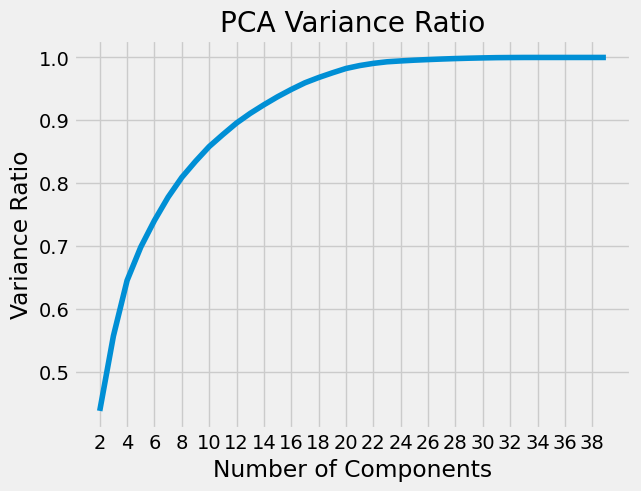

In [96]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [97]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.19177354e-01 8.84100474e-02 5.30726098e-02 4.23397953e-02
 3.71773991e-02 3.13672696e-02 2.54857256e-02 2.35563402e-02
 1.91276355e-02 1.83087936e-02 1.53608362e-02 1.36931394e-02
 1.27971287e-02 1.15907965e-02 1.05884979e-02 8.35850017e-03
 7.45936965e-03 6.95989894e-03 4.64823258e-03 3.48459720e-03
 2.51342673e-03 1.36612418e-03 1.21853286e-03 9.57318809e-04
 8.54592061e-04 7.36991600e-04 5.97378652e-04 4.75716616e-04
 3.83648650e-04 1.75231173e-04 1.17747116e-04 1.42325451e-05
 6.10520329e-07 8.90670145e-08 5.77143067e-09 2.34618636e-09
 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

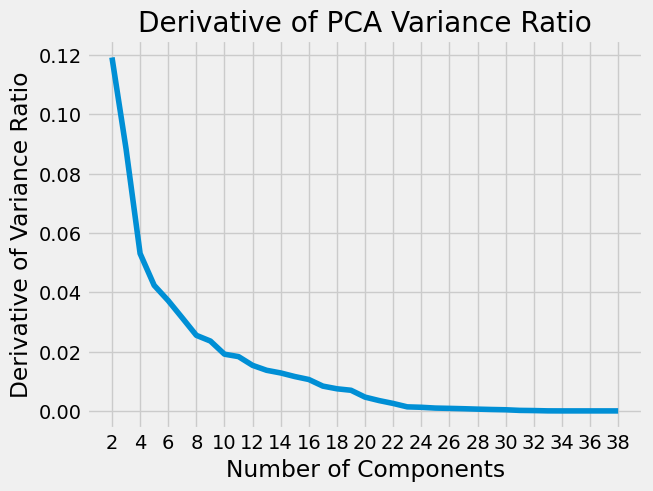

In [98]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [99]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.22653738 0.21108701 0.11917735 0.08841005 0.05307261 0.0423398
 0.0371774  0.03136727 0.02548573 0.02355634 0.01912764 0.01830879
 0.01536084 0.01369314 0.01279713 0.0115908 ]
0.9490892548236328


In [100]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}\n")

Silhouette Score with 2 clusters: 0.16372179986488297

Silhouette Score with 3 clusters: 0.19784780946229505

Silhouette Score with 4 clusters: 0.17281385643566496

Silhouette Score with 5 clusters: 0.14829030749227404

Silhouette Score with 6 clusters: 0.13246986015543424

Silhouette Score with 7 clusters: 0.1216765644191826

Silhouette Score with 8 clusters: 0.12635357651327309

Silhouette Score with 9 clusters: 0.12498155555569553

Silhouette Score with 10 clusters: 0.12176109040140884

Silhouette Score with 11 clusters: 0.11156071185023983

Silhouette Score with 12 clusters: 0.10568551537032118

Silhouette Score with 13 clusters: 0.10572943499084647

Silhouette Score with 14 clusters: 0.11463590364429767

Silhouette Score with 15 clusters: 0.10995708262733327

Silhouette Score with 16 clusters: 0.10262621198775794

Silhouette Score with 17 clusters: 0.09988787147057068

Silhouette Score with 18 clusters: 0.09128445243713118

Silhouette Score with 19 clusters: 0.08848213030657723

S

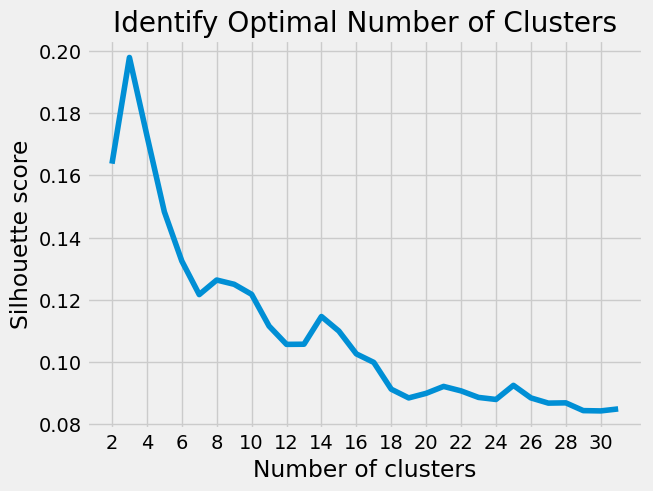

In [101]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [102]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluster = {i + 2}, improvement = {improvement}") 

for n_cluster = 3, improvement = 0.04080700607991261
for n_cluster = 4, improvement = -0.03120848303094359
for n_cluster = 5, improvement = -0.02964695326945299
for n_cluster = 6, improvement = -0.018574929316888422
for n_cluster = 7, improvement = -0.01244140720942033
for n_cluster = 8, improvement = 0.005324931459898541
for n_cluster = 9, improvement = -0.0015704533558345002
for n_cluster = 10, improvement = -0.003680454023265778
for n_cluster = 11, improvement = -0.011614582819874375
for n_cluster = 12, improvement = -0.006612940870899697
for n_cluster = 13, improvement = 4.910981682626492e-05
for n_cluster = 14, improvement = 0.009959478710294012
for n_cluster = 15, improvement = -0.005284629268594854
for n_cluster = 16, improvement = -0.008236536122567584
for n_cluster = 17, improvement = -0.003051504906615321
for n_cluster = 18, improvement = -0.009558163656227414
for n_cluster = 19, improvement = -0.003083827648893811
for n_cluster = 20, improvement = 0.0016162844990833536
for n

C:\conda_tmp\ipykernel_14448\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


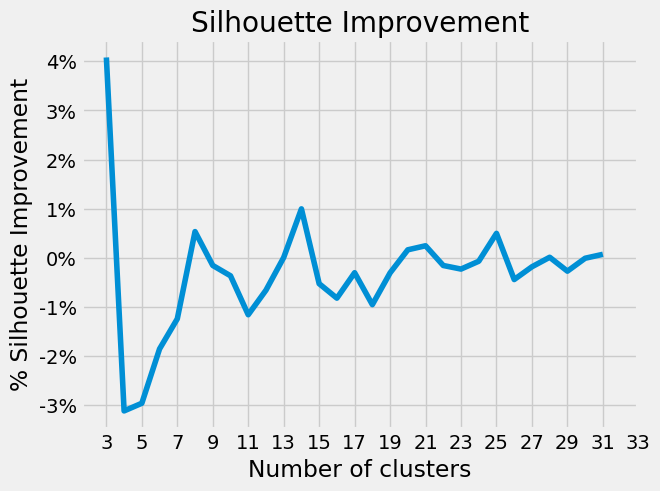

In [103]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [104]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
# with open("../models/clusterMode.sav", 'wb') as f:
#     pickle.dump(kmeans, f)

In [105]:
# Create and save cluster assignments
df_cluster = pd.DataFrame({
    'PLAYER': dfPlayerCol['PLAYER'],
    'CLUSTER': y_kmeans,
    'TIMESTAMP': pd.Timestamp.now()
})

# Save only current version to S3
save_dataframe_to_s3(df_cluster, 'data/clustered_players/current.parquet')

print("\nClustering Summary:")
print(f"Total Players: {len(df_cluster)}")
print(f"Number of Clusters: {len(np.unique(y_kmeans))}")
print(f"Silhouette Score: {silhouette_score(x, y_kmeans):.3f}")

df_cluster.head()

Saved 404 records to s3://nba-prediction-ibracken/data/clustered_players/current.parquet

Clustering Summary:
Total Players: 404
Number of Clusters: 15
Silhouette Score: 0.110


,PLAYER,CLUSTER,TIMESTAMP
0,a.j. lawson,13,2025-08-27 20:09:08.540588
1,aj green,7,2025-08-27 20:09:08.540588
2,aj johnson,1,2025-08-27 20:09:08.540588
3,aaron gordon,14,2025-08-27 20:09:08.540588
4,aaron holiday,12,2025-08-27 20:09:08.540588


In [106]:
# Print summary of clusters
cluster_counts = df_cluster['CLUSTER'].value_counts().sort_index()
print("\nPlayers per cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} players")


Players per cluster:
Cluster 0: 6 players
Cluster 1: 42 players
Cluster 2: 30 players
Cluster 3: 39 players
Cluster 4: 26 players
Cluster 5: 16 players
Cluster 6: 27 players
Cluster 7: 40 players
Cluster 8: 30 players
Cluster 9: 18 players
Cluster 10: 35 players
Cluster 11: 29 players
Cluster 12: 15 players
Cluster 13: 29 players
Cluster 14: 22 players
